In [108]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [109]:
def cartoonify_image(image_path):
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply median blur for noise reduction
    gray_blur = cv2.medianBlur(gray, 7)
    
    # Apply Laplacian filter for edge detection
    edges = cv2.Laplacian(gray_blur, cv2.CV_8U, ksize=5)
    edges_thresh = cv2.threshold(edges, 30, 255, cv2.THRESH_BINARY)[1]
    img_small = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2))
    for _ in range(30):
        img_small = cv2.bilateralFilter(img_small, 9, 100, 300)
    color = cv2.resize(img_small, (img.shape[1], img.shape[0]))
    
    
    # Combine edges with the color image
    edges_inv = cv2.bitwise_not(edges_thresh)
    #cartoon = cv2.addWeighted(color, 0.8, cv2.cvtColor(edges_inv, cv2.COLOR_GRAY2RGB), 0.2, 0)
    cartoon = cv2.bitwise_and(color, color, mask=edges_inv)
    
    # Show results
    plt.figure(figsize=(20, 10)),plt.subplot(2, 3, 1),plt.imshow(img),plt.title("Original Image"),plt.axis("off")

    plt.subplot(2, 3, 2),plt.imshow(gray, cmap="gray"),plt.title("Grayscale Image"),plt.axis("off")

    plt.subplot(2, 3, 3),plt.imshow(gray_blur, cmap="gray"),plt.title("After Median Blur"),plt.axis("off")

    plt.subplot(2, 3, 4),plt.imshow(edges, cmap="gray"),plt.title("Edge Detection (Laplacian)"),plt.axis("off")

    plt.subplot(2, 3, 5),plt.imshow(edges_inv, cmap="gray"),plt.title("Edge Detection (Thresholded)"),plt.axis("off")

    plt.subplot(2, 3, 6),plt.imshow(cartoon),plt.title("Cartoon Effect"),plt.axis("off")

    plt.show()

In [110]:
def detect_lanes(image_path):
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)
    
    # Define Region of Interest (ROI)
    height, width = edges.shape
    mask = np.zeros_like(edges)
    polygon = np.array([[(50, height), (width-50, height), (width//2, height//2)]], np.int32)
    cv2.fillPoly(mask, polygon, 255)
    roi_edges = cv2.bitwise_and(edges, mask)
    
    # Detect lanes using Hough Transform
    lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, 50, minLineLength=100, maxLineGap=50)
    result = img.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(result, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
    # Show results
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1), plt.imshow(img), plt.title("Original Image"), plt.axis("off")
    plt.subplot(1,3,2), plt.imshow(edges, cmap='gray'), plt.title("Edge Detection"), plt.axis("off")
    plt.subplot(1,3,3), plt.imshow(result), plt.title("Lane Detection"), plt.axis("off")
    plt.show()

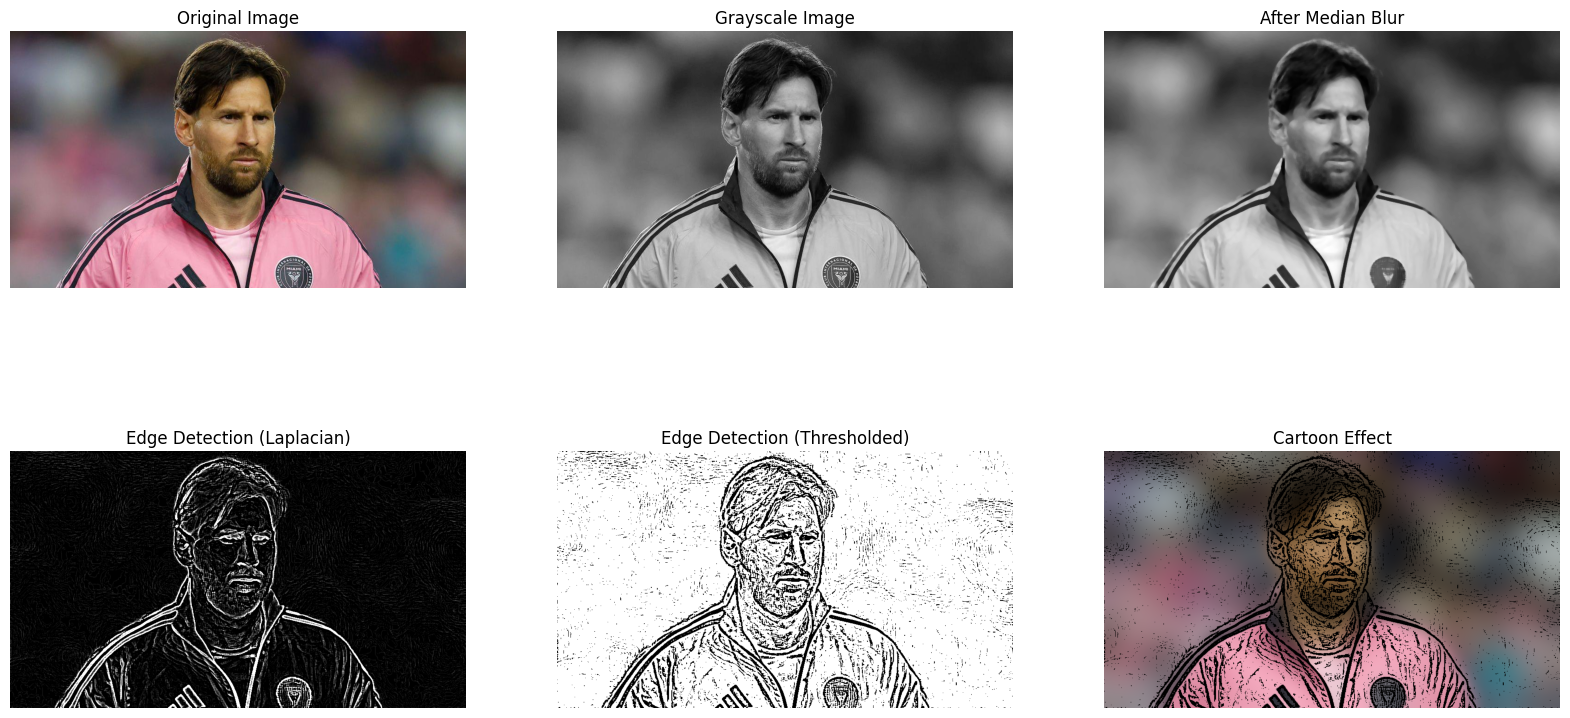

In [111]:
cartoonify_image("test images/Goat.jpg")
# detect_lanes("test2.png")

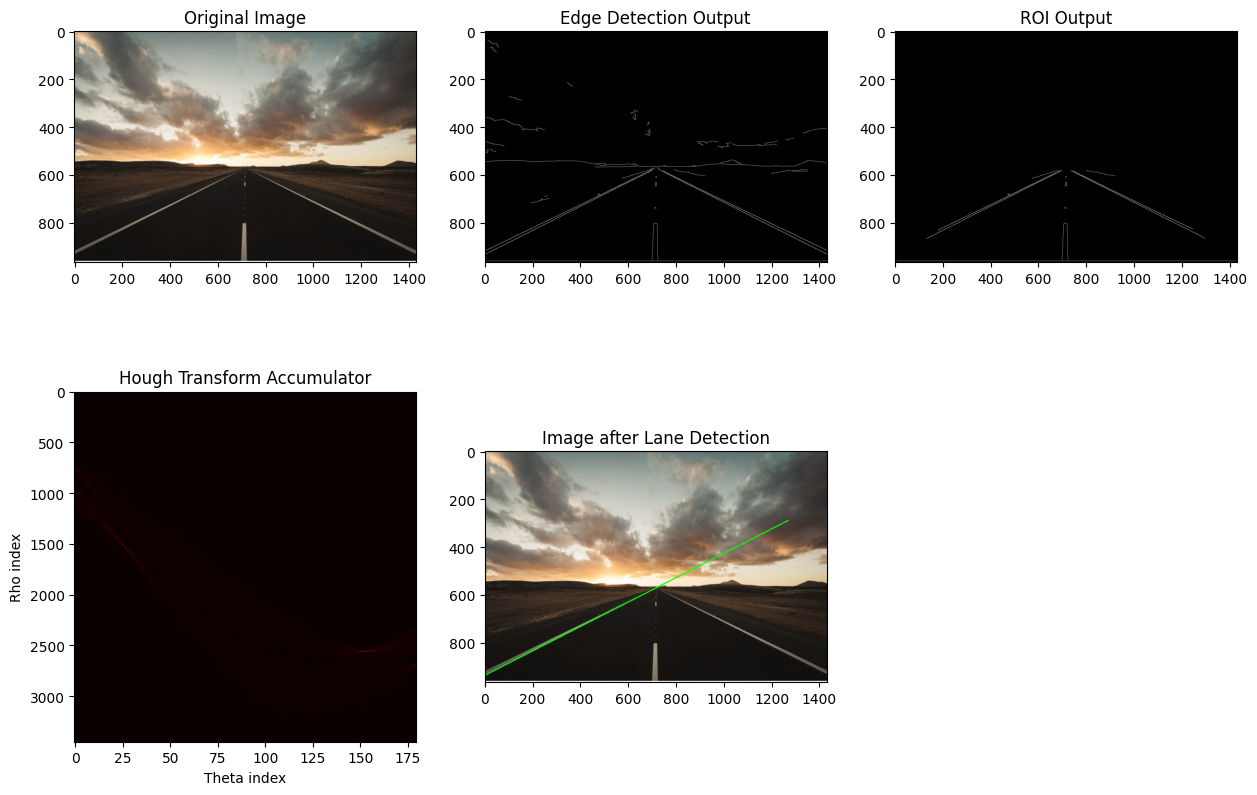

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def median_smoothing(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def region_of_interest(image):
    height, width = image.shape
    mask = np.zeros_like(image)

    # Adjusted trapezoidal ROI that removes the sky
    polygon = np.array([
        [(0, height), (width // 2 - 200, height // 2 + 100), 
         (width // 2 + 200, height // 2 + 100), (width, height)]
    ], dtype=np.int32)

    cv2.fillPoly(mask, polygon, 255)
    return cv2.bitwise_and(image, mask)


def hough_transform(image, theta_res=1, rho_res=1):
    # Apply median smoothing
    smoothed = median_smoothing(image)
    
    # Edge detection using Canny
    edges = cv2.Canny(smoothed, 50, 150)
    roi_edges = region_of_interest(edges)
    height, width = roi_edges.shape

    # Theta ranges from -90 to 90 degrees
    theta = np.deg2rad(np.arange(-90, 90, theta_res))
    max_rho = int(np.hypot(height, width))
    rhos = np.arange(-max_rho, max_rho, rho_res)

    # Accumulator array
    accumulator = np.zeros((len(rhos), len(theta)), dtype=int)

    # Find edge points
    edge_points = np.argwhere(roi_edges)

    # Vote in the accumulator
    for y, x in edge_points:
        for t_idx, t in enumerate(theta):
            rho = int(x * np.cos(t) + y * np.sin(t))
            rho_idx = np.where(rhos == rho)[0]
            if rho_idx.size > 0:
                accumulator[rho_idx[0], t_idx] += 1

    return accumulator, theta, rhos, edges, roi_edges

def find_peak_lines(accumulator, theta, rhos, threshold=100):
    lines = []
    for rho_idx in range(accumulator.shape[0]):
        for theta_idx in range(accumulator.shape[1]):
            if accumulator[rho_idx, theta_idx] > threshold:
                rho = rhos[rho_idx]
                theta_val = theta[theta_idx]
                        # Filter out unwanted angles
    angle_deg = np.rad2deg(theta_val)
    if 30 <= angle_deg <= 70 or 140 <= angle_deg <= 150:
        lines.append((rho, theta_val))

    return lines


def draw_detected_lines(image, lines):
    if len(image.shape) == 2:  # Convert grayscale to BGR if needed
        line_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        line_image = image.copy()
    
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 3)
    return line_image

# Load and process the image
image = cv2.imread('test3.png', cv2.IMREAD_GRAYSCALE)
accumulator, theta, rhos, edges, roi_edges = hough_transform(image)
lines = find_peak_lines(accumulator, theta, rhos, threshold=150)
detected_image = draw_detected_lines(cv2.imread('test3.png'), lines)

# Show results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(cv2.imread('test3.png'), cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(2, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection Output')

plt.subplot(2, 3, 3)
plt.imshow(roi_edges, cmap='gray')
plt.title('ROI Output')

plt.subplot(2, 3, 4)
plt.imshow(accumulator, cmap='hot', aspect='auto')
plt.title('Hough Transform Accumulator')
plt.xlabel('Theta index')
plt.ylabel('Rho index')

plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.title('Image after Lane Detection')

plt.show()
